# Ligand-based Target Prediction Tutorial

### George Papadatos, ChEMBL Group, EMBL-EBI.

This is a short tutorial on getting target predictions based on the current multi-category Naive Bayesian [ChEMBL_18 models](http://chembl.blogspot.co.uk/2014/04/ligand-based-target-predictions-in.html) for a single molecule input. The predictions are ranked by the output classifier probability or score.

This is the outline of the tutorial
* Download the models
* Input a molecule to get target predictions for it
* Assess the predictions
* Retrieve individual feature contributions for a prediction

### First of all, get the models from the ChEMBL ftp site. You only need to run this once.

In [ ]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/chembl/target_predictions/chembl_18_models.tar.gz

--2017-10-04 18:19:09--  ftp://ftp.ebi.ac.uk/pub/databases/chembl/target_predictions/chembl_18_models.tar.gz
           => 'chembl_18_models.tar.gz'
Resolving ftp.ebi.ac.uk... 193.62.192.4
Connecting to ftp.ebi.ac.uk|193.62.192.4|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/chembl/target_predictions ... done.
==> SIZE chembl_18_models.tar.gz ... 56545450
==> PASV ... done.    ==> RETR chembl_18_models.tar.gz ... done.
Length: 56545450 (54M) (unauthoritative)

chembl_18_models.ta  24%[===>                ]  13.02M   210KB/s    eta 3m 53s 

In [3]:
!tar -zxf chembl_18_models.tar.gz

The two models are now under ./models

Import the necessary modules:

In [104]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw

import pandas as pd
from pandas import concat

from collections import OrderedDict

import requests

In [105]:
from sklearn.externals import joblib

In [107]:
%matplotlib

Using matplotlib backend: module://IPython.kernel.zmq.pylab.backend_inline


In [108]:
rcParams['figure.figsize'] = 10,10

A couple of utility functions:

In [109]:
def calc_scores(classes):
    p = []
    for c in classes:
        p.append(pred_score(c))
    return p

In [110]:
def pred_score(trgt):
    diff = morgan_nb.estimators_[classes.index(trgt)].feature_log_prob_[1] - morgan_nb.estimators_[classes.index(trgt)].feature_log_prob_[0]
    return sum(diff*fp)

Load one of the two models:

In [111]:
morgan_nb = joblib.load('./models/10uM/mNB_10uM_all.pkl')

In [112]:
classes = list(morgan_nb.classes_)

In [113]:
morgan_nb.multilabel_

True

Check the number of classses/targets:

In [114]:
len(classes)

1244

### Get predictions for a compound

Let's use a molecule (GS-5759) found in [this](http://www.ncbi.nlm.nih.gov/pubmed/24513870) publication. It is a novel compound (not in ChEMBL) reported to have dual activity against PDE4 and beta-2 adrenergic receptor. 

In [115]:
smiles = 'O[C@@H](CNCCCC#CC1=CC=C(C=C1)NC(=O)C=1C=C(C=CC1)S(=O)(=O)C=1C=C2C(=C(C=NC2=C(C1)C)C(=O)N)NC1=CC(=CC=C1)OC)C1=C2C=CC(NC2=C(C=C1)O)=O' #GS-5759

In [116]:
mol = Chem.MolFromSmiles(smiles)

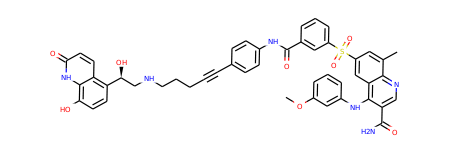

In [117]:
mol

Convert to the Morgan fingerprint and save the bit dictionary for later...

In [118]:
info={}
fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048, bitInfo=info)

Get the predictions in a Pandas frame

In [119]:
predictions = pd.DataFrame(zip(classes, calc_scores(classes),list(morgan_nb.predict_proba(fp)[0])),columns=['id','score','proba'])

In [120]:
predictions.head()

,id,score,proba
0,CHEMBL1075051,-49.683154,5.836404e-26
1,CHEMBL1075104,-22.709670,1.221899e-13
2,CHEMBL1075108,-76.563053,6.262378e-38
3,CHEMBL1075111,-81.947712,2.656745e-40
4,CHEMBL1075115,-13.045515,5.122346e-10


Let's check the distributions of prediction probability and score for the 1244 targets.

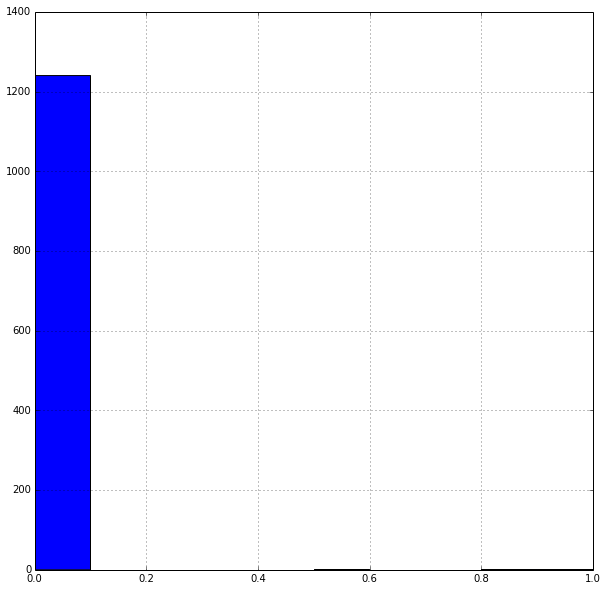

In [121]:
predictions['proba'].hist()

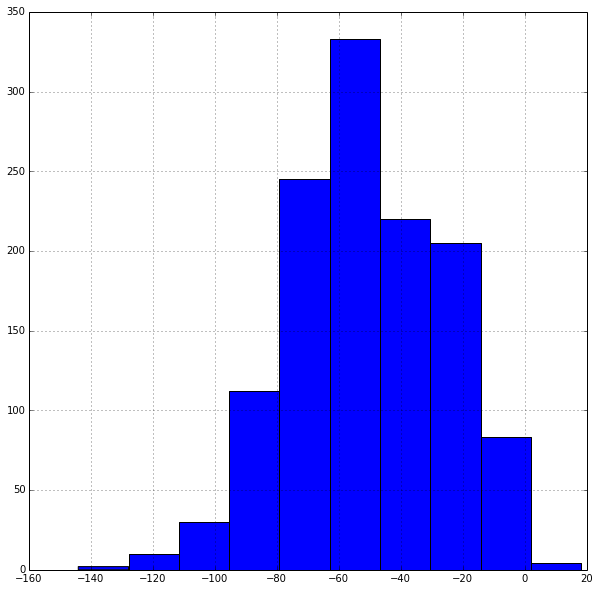

In [122]:
predictions['score'].hist()

Sort by probability and take top 10.

In [123]:
top_preds = predictions.sort(columns=['proba'],ascending=False).head(10)

In [124]:
top_preds

,id,score,proba
1124,CHEMBL5414,18.159497,0.999977
568,CHEMBL3252,10.654329,0.874618
409,CHEMBL275,7.960013,0.843829
210,CHEMBL210,6.068692,0.558651
216,CHEMBL213,-1.089044,0.000909
616,CHEMBL3397,-4.842163,0.000119
85,CHEMBL1844,-4.558361,0.000024
746,CHEMBL3864,-3.178081,0.000024
28,CHEMBL1293224,-8.120585,0.000020
618,CHEMBL340,-7.057586,0.000017


Use ChEMBL WS to merge with target information

In [125]:
def fetch_WS(trgt):
    re = requests.get('https://www.ebi.ac.uk/chemblws/targets/{0}.json'.format(trgt))
    return re.json()['target']

In [126]:
plist = []
for i,e in enumerate(top_preds['id']):
    p = pd.DataFrame(fetch_WS(e), index=(i,))
    plist.append(p)
target_info = concat(plist)

In [127]:
target_info.shape

(10, 10)

In [128]:
target_info

,bioactivityCount,chemblId,compoundCount,description,geneNames,organism,preferredName,proteinAccession,synonyms,targetType
0,1038,CHEMBL5414,567,Beta-2 adrenergic receptor,Unspecified,Cavia porcellus,Beta-2 adrenergic receptor,Q8K4Z4,"Adrb2,Beta-2 adrenoreceptor,Beta-2 adrenoceptor,Beta-2 adrenergic receptor",SINGLE PROTEIN
1,421,CHEMBL3252,298,Beta-1 adrenergic receptor,Unspecified,Rattus norvegicus,Beta-1 adrenergic receptor,P18090,"Beta-1 adrenoceptor,Adrb1r,Beta-1 adrenergic receptor,Adrb1,Beta-1 adrenoreceptor",SINGLE PROTEIN
2,1127,CHEMBL275,997,Phosphodiesterase 4B,Unspecified,Homo sapiens,Phosphodiesterase 4B,Q07343,"3.1.4.53,cAMP-specific 3',5'-cyclic phosphodiesterase 4B,DPDE4,PDE32,PDE4B",SINGLE PROTEIN
3,6595,CHEMBL210,4320,Beta-2 adrenergic receptor,Unspecified,Homo sapiens,Beta-2 adrenergic receptor,P07550,"Beta-2 adrenergic receptor,ADRB2,Beta-2 adrenoreceptor,Beta-2 adrenoceptor,ADRB2R ,B2AR",SINGLE PROTEIN
4,4380,CHEMBL213,2716,Beta-1 adrenergic receptor,Unspecified,Homo sapiens,Beta-1 adrenergic receptor,P08588,"ADRB1,ADRB1R ,B1AR,Beta-1 adrenergic receptor,Beta-1 adrenoreceptor,Beta-1 adrenoceptor",SINGLE PROTEIN
5,26321,CHEMBL3397,21212,Cytochrome P450 2C9,Unspecified,Homo sapiens,Cytochrome P450 2C9,P11712,"(R)-limonene 6-monooxygenase,CYP2C9,Cytochrome P450 MP-4,CYP2C10,Cytochrome P450 MP-8,(S)-limonene 7-monooxygenase,1.14.13.-,S-mephenytoin 4-hydroxylase,CYPIIC9,Cytochrome P-450MP,Cytochrome P450 2C9,1.14.13.48,1.14.13.49,1.14.13.80,(S)-limonene 6-monooxygenase,Cytochrome P450 PB-1",SINGLE PROTEIN
6,3061,CHEMBL1844,2245,Macrophage colony stimulating factor receptor,Unspecified,Homo sapiens,Macrophage colony stimulating factor receptor,P07333,"CD_antigen=CD115,FMS,Proto-oncogene c-Fms,CSF-1 receptor,CSF1R,2.7.10.1,CSF-1R,Macrophage colony-stimulating factor 1 receptor,CSF-1-R,M-CSF-R",SINGLE PROTEIN
7,578,CHEMBL3864,528,Protein-tyrosine phosphatase 2C,Unspecified,Homo sapiens,Protein-tyrosine phosphatase 2C,Q06124,"PTP2C ,Protein-tyrosine phosphatase 1D,SH-PTP2,Shp2,PTP-2C,PTPN11,3.1.3.48,Protein-tyrosine phosphatase 2C,Tyrosine-protein phosphatase non-receptor type 11,PTP-1D,SHPTP2,SH-PTP3,SHP-2",SINGLE PROTEIN
8,94907,CHEMBL1293224,66755,Microtubule-associated protein tau,Unspecified,Homo sapiens,Microtubule-associated protein tau,P10636,"Neurofibrillary tangle protein,TAU,Microtubule-associated protein tau,MAPT,MTBT1,MAPTL ,Paired helical filament-tau,PHF-tau",SINGLE PROTEIN
9,41780,CHEMBL340,25658,Cytochrome P450 3A4,Unspecified,Homo sapiens,Cytochrome P450 3A4,P08684,"Cytochrome P450-PCN1,Quinine 3-monooxygenase,1.14.13.32,CYPIIIA3,CYPIIIA4,Cytochrome P450 3A4,Taurochenodeoxycholate 6-alpha-hydroxylase,1.14.13.157,1.14.13.97,CYP3A3,Nifedipine oxidase,Albendazole monooxygenase,Cytochrome P450 3A3,1,8-cineole 2-exo-monooxygenase,1.14.13.-,1.14.13.67,Albendazole sulfoxidase,Cytochrome P450 NF-25,CYP3A4,Cytochrome P450 HLp",SINGLE PROTEIN


Finally, let's get the complete top 10 target predictions in descreasing order of probability.

In [129]:
result = pd.merge(top_preds, target_info, left_on='id', right_on='chemblId')

In [130]:
result

,id,score,proba,bioactivityCount,chemblId,compoundCount,description,geneNames,organism,preferredName,proteinAccession,synonyms,targetType
0,CHEMBL5414,18.159497,0.999977,1038,CHEMBL5414,567,Beta-2 adrenergic receptor,Unspecified,Cavia porcellus,Beta-2 adrenergic receptor,Q8K4Z4,"Adrb2,Beta-2 adrenoreceptor,Beta-2 adrenoceptor,Beta-2 adrenergic receptor",SINGLE PROTEIN
1,CHEMBL3252,10.654329,0.874618,421,CHEMBL3252,298,Beta-1 adrenergic receptor,Unspecified,Rattus norvegicus,Beta-1 adrenergic receptor,P18090,"Beta-1 adrenoceptor,Adrb1r,Beta-1 adrenergic receptor,Adrb1,Beta-1 adrenoreceptor",SINGLE PROTEIN
2,CHEMBL275,7.960013,0.843829,1127,CHEMBL275,997,Phosphodiesterase 4B,Unspecified,Homo sapiens,Phosphodiesterase 4B,Q07343,"3.1.4.53,cAMP-specific 3',5'-cyclic phosphodiesterase 4B,DPDE4,PDE32,PDE4B",SINGLE PROTEIN
3,CHEMBL210,6.068692,0.558651,6595,CHEMBL210,4320,Beta-2 adrenergic receptor,Unspecified,Homo sapiens,Beta-2 adrenergic receptor,P07550,"Beta-2 adrenergic receptor,ADRB2,Beta-2 adrenoreceptor,Beta-2 adrenoceptor,ADRB2R ,B2AR",SINGLE PROTEIN
4,CHEMBL213,-1.089044,0.000909,4380,CHEMBL213,2716,Beta-1 adrenergic receptor,Unspecified,Homo sapiens,Beta-1 adrenergic receptor,P08588,"ADRB1,ADRB1R ,B1AR,Beta-1 adrenergic receptor,Beta-1 adrenoreceptor,Beta-1 adrenoceptor",SINGLE PROTEIN
5,CHEMBL3397,-4.842163,0.000119,26321,CHEMBL3397,21212,Cytochrome P450 2C9,Unspecified,Homo sapiens,Cytochrome P450 2C9,P11712,"(R)-limonene 6-monooxygenase,CYP2C9,Cytochrome P450 MP-4,CYP2C10,Cytochrome P450 MP-8,(S)-limonene 7-monooxygenase,1.14.13.-,S-mephenytoin 4-hydroxylase,CYPIIC9,Cytochrome P-450MP,Cytochrome P450 2C9,1.14.13.48,1.14.13.49,1.14.13.80,(S)-limonene 6-monooxygenase,Cytochrome P450 PB-1",SINGLE PROTEIN
6,CHEMBL1844,-4.558361,0.000024,3061,CHEMBL1844,2245,Macrophage colony stimulating factor receptor,Unspecified,Homo sapiens,Macrophage colony stimulating factor receptor,P07333,"CD_antigen=CD115,FMS,Proto-oncogene c-Fms,CSF-1 receptor,CSF1R,2.7.10.1,CSF-1R,Macrophage colony-stimulating factor 1 receptor,CSF-1-R,M-CSF-R",SINGLE PROTEIN
7,CHEMBL3864,-3.178081,0.000024,578,CHEMBL3864,528,Protein-tyrosine phosphatase 2C,Unspecified,Homo sapiens,Protein-tyrosine phosphatase 2C,Q06124,"PTP2C ,Protein-tyrosine phosphatase 1D,SH-PTP2,Shp2,PTP-2C,PTPN11,3.1.3.48,Protein-tyrosine phosphatase 2C,Tyrosine-protein phosphatase non-receptor type 11,PTP-1D,SHPTP2,SH-PTP3,SHP-2",SINGLE PROTEIN
8,CHEMBL1293224,-8.120585,0.000020,94907,CHEMBL1293224,66755,Microtubule-associated protein tau,Unspecified,Homo sapiens,Microtubule-associated protein tau,P10636,"Neurofibrillary tangle protein,TAU,Microtubule-associated protein tau,MAPT,MTBT1,MAPTL ,Paired helical filament-tau,PHF-tau",SINGLE PROTEIN
9,CHEMBL340,-7.057586,0.000017,41780,CHEMBL340,25658,Cytochrome P450 3A4,Unspecified,Homo sapiens,Cytochrome P450 3A4,P08684,"Cytochrome P450-PCN1,Quinine 3-monooxygenase,1.14.13.32,CYPIIIA3,CYPIIIA4,Cytochrome P450 3A4,Taurochenodeoxycholate 6-alpha-hydroxylase,1.14.13.157,1.14.13.97,CYP3A3,Nifedipine oxidase,Albendazole monooxygenase,Cytochrome P450 3A3,1,8-cineole 2-exo-monooxygenase,1.14.13.-,1.14.13.67,Albendazole sulfoxidase,Cytochrome P450 NF-25,CYP3A4,Cytochrome P450 HLp",SINGLE PROTEIN


Not bad! The model retrieved the correct targets in the top 4 predictions out of a pool of 1244 targets.

### Feature contribution

Now let's look at contributions of specific substructural features to the PDE4 predictions. Which features of the active molecules in the training set were the most important?

In [131]:
bit_scores = (morgan_nb.estimators_[classes.index(result['id'][2])].feature_log_prob_[1] - morgan_nb.estimators_[classes.index(result['id'][2])].feature_log_prob_[0])*fp

The snippet below maps the specific bits back to atomic environments

In [132]:
frags = OrderedDict()
for k in info.keys():
    if bit_scores[k] > 0.1:
        atomId,radius = info[k][0]
        env=Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomId)
        ats = set([atomId])
        for bidx in env:
            bond = mol.GetBondWithIdx(bidx)
            ats.add(bond.GetBeginAtomIdx())
            ats.add(bond.GetEndAtomIdx())
            frag = Chem.MolFragmentToSmiles(mol,atomsToUse=list(ats),bondsToUse=env,rootedAtAtom=atomId)
            legend = str(round(bit_scores[k],2))
            frags[k] = (legend,frag)

In [133]:
legends = [l[1][0] for l in sorted(frags.items(), key=lambda t: t[1][0], reverse=True)][:10]
ffrags = [l[1][1] for l in sorted(frags.items(), key=lambda t: t[1][0], reverse=True)][:10]

In [134]:
fmols=[Chem.MolFromSmarts(s) for s in ffrags]

This was the original molecule

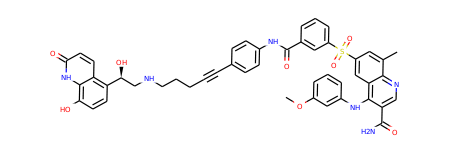

In [135]:
mol

And these are its most important features, based on their enrichent in PDE4B actives in ChEMBL. The legend is the Bayesian score for each feature. 

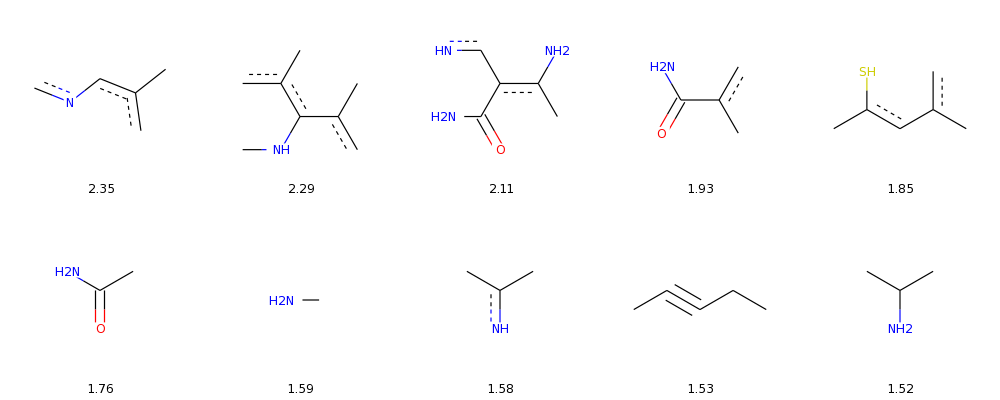

In [136]:
Draw.MolsToGridImage(fmols, molsPerRow=5, legends=legends)